# Starting with lots of data and a good understanding of that data from *lifespan_of_companies*, we'll make a function to put in an API that will return the probability of a company going out of business in the next 2 years.


## Step 1: get the data ready for analysis

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import elasticsearch
import elasticsearch.helpers
import collections
from pandas.io.json import json_normalize

In [12]:
# Data goes from Elasticsearch into Pandas:
es = elasticsearch.Elasticsearch()

data_to_load = elasticsearch.helpers.scan(
                    es,
                    query={"query": {"match_all": {}}},
                    index="ri_sos",
                    doc_type="corporate_data")

# Initialize a double ended queue
output_all = collections.deque()
# Extend deque with iterator
output_all.extend(data_to_load)
only_data = [item["_source"] for item in output_all]

df = json_normalize(only_data)
print(df.shape)

(43684, 23)


## Add needed variables and, using what we learned in `lifespan_of_companies`, delete bad data
### First our dependent variable: log_time_in_business

In [16]:
# Convert date columns to the date format
df['InactiveDate'] = pd.to_datetime(df['InactiveDate']).dt.date
df['OrganisationDate'] = pd.to_datetime(df['OrganisationDate']).dt.date

# Add the variable 'time_in_business' when we can calculate it:
df.loc[df['InactiveDate'] != np.nan, 'time_in_business'] = (df['InactiveDate'] - df['OrganisationDate']).dt.days

In [17]:
# Find examples where 'time_in_business' is negative (entity disolved before being formed, which is impossible):
weird_rows = df.loc[df.time_in_business < 0]
print(weird_rows.IDNumber)

3011     000000417
29616    000000417
30541    000002273
Name: IDNumber, dtype: object


In [18]:
# If manual inspection shows you should delete them, then delete negatives and 0s:
df.drop(df[df.time_in_business < 1].index, inplace=True)
print("Resulting shape:", df.shape)

Resulting shape: (43677, 24)


In [19]:
df.time_in_business.describe()

count    32455.000000
mean      3515.187829
std       4116.401240
min          1.000000
25%       1030.000000
50%       2120.000000
75%       4303.000000
max      61626.000000
Name: time_in_business, dtype: float64

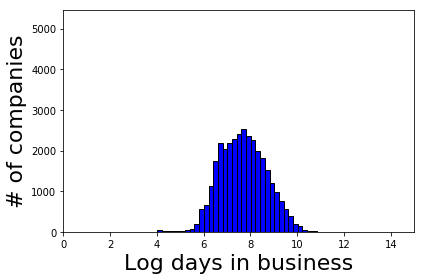

In [31]:
# This variable is much more appropriate to work with as a log.
# I did a lot of work on the best way to work with this variable in `lifespan_of_companies`, and here's the conclusion:

## TODO: clean this up, do it all on df
first_tib = df[["time_in_business", "IDNumber"]].copy()
first_tib["log_tib"] = np.log(first_tib.time_in_business)
first_tib['masked_tib'] = first_tib['log_tib']
first_tib.loc[first_tib.log_tib < 4, 'masked_tib'] = 4
df["log_time_in_business"] = first_tib['masked_tib']

# Graph it:
plt.hist(df.log_time_in_business, bins = 35,
         color = 'blue', edgecolor = 'black')
plt.axis([0, 15, 0, df.shape[0] / 8])
plt.xlabel('Log days in business', size = 22)
plt.ylabel('# of companies', size= 22)

plt.tight_layout()
plt.show()

### Make variables for the most common words in entity's names & descriptions, then remove useless ones